<a href="https://colab.research.google.com/github/momenashra/Algorithms/blob/main/Time_series_analysis_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [ ]:
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils import plot_model
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns  # visualization tool



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


# Read the uploaded CSV file
df = pd.read_csv("/content/drive/MyDrive/projectdata.xlsx")  # Replace with the actual file name
df['Date'] = pd.to_datetime(df['date'])
df['Date'] = df['Date'].dt.date

In [ ]:
# Sort the DataFrame by 'Date'
df = df.sort_values(by='Date')

# Set 'Date' as the index
df.set_index('Date', inplace=True)

In [ ]:
df.head()

,quantity,UnitePrice,discount,date,retail price,product_name,area,city
Date,,,,,,,,
2021-03-31,5,102.0,33.0,2021-03-31T11:38:58Z,102.0,product x,El-Mokattam,Cairo
2021-04-30,1,16.0,9.0,2021-04-30T20:56:54Z,16.0,product y,Ain Shams,Cairo
2021-05-08,10,16.0,9.0,2021-05-08T14:12:52Z,16.0,product y,El-Zaitoun,Cairo
2021-05-08,10,45.0,22.0,2021-05-08T14:12:52Z,45.0,product z,El-Zaitoun,Cairo
2021-05-22,10,16.0,20.0,2021-05-22T10:56:31Z,16.0,product y,Bakos,North


In [ ]:
df.drop(df[df['discount'] < 0].index, inplace=True)

In [ ]:
df.drop(columns=['area','date'], inplace=True)


In [ ]:
df

,quantity,UnitePrice,discount,retail price,product_name,city
Date,,,,,,
2021-03-31,5,102.0,33.0,102.0,product x,Cairo
2021-04-30,1,16.0,9.0,16.0,product y,Cairo
2021-05-08,10,16.0,9.0,16.0,product y,Cairo
2021-05-08,10,45.0,22.0,45.0,product z,Cairo
2021-05-22,10,16.0,20.0,16.0,product y,North
...,...,...,...,...,...,...
2023-01-17,2,99.0,27.0,99.0,product x,North
2023-01-17,5,99.0,28.0,99.0,product x,North
2023-01-17,1,99.0,27.0,99.0,product x,North


In [ ]:
# df['total price'] = df['UnitePrice'] * df['quantity']

In [ ]:
df.describe()

,quantity,UnitePrice,discount,retail price
count,2993.000000,2993.000000,2993.000000,2993.000000
mean,7.708654,60.560558,25.924186,59.620281
std,100.499514,35.268629,14.120006,36.944413
min,1.000000,10.000000,0.000000,0.000000
25%,2.000000,16.000000,20.000000,16.000000
50%,3.000000,45.000000,31.000000,45.000000
75%,5.000000,99.000000,33.000000,99.000000
max,5000.000000,102.000000,561.000000,102.000000


In [ ]:
df.isnull().sum()  # Shows the count of missing values per column

In [ ]:
columns_to_check = ['quantity', 'UnitePrice', 'discount', 'retail price']

# Loop through each column and remove outliers
df_filtered = df.copy()  # Copy the original DataFrame to keep it intact

for column in columns_to_check:
    # Calculate Q1 and Q3 for the column
    Q1 = df_filtered[column].quantile(0.25)
    Q3 = df_filtered[column].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers by filtering data within bounds
    df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]



In [ ]:
df_filtered.describe()

,quantity,UnitePrice,discount,retail price
count,2480.000000,2480.000000,2480.000000,2480.000000
mean,2.811694,65.444052,27.512254,64.242339
std,1.640927,33.805854,8.420025,35.863974
min,1.000000,10.000000,3.000000,0.000000
25%,1.000000,45.000000,27.000000,45.000000
50%,2.000000,89.750000,31.000000,89.750000
75%,4.000000,99.000000,33.000000,99.000000
max,9.000000,102.000000,38.000000,102.000000


In [ ]:
# Create a pivot table
pivot_df = df_filtered.pivot_table(
    index='Date',
    columns=['product_name','city'],
    values=['quantity', 'UnitePrice', 'discount', 'retail price'],
    aggfunc='sum',
    fill_value=0
)

# Flatten the multi-level columns
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

# Reset the index to turn 'Date' back into a column if needed
pivot_df.reset_index(inplace=True)


In [ ]:
pivot_df.head(10)

,Date,UnitePrice_product x _Cairo,UnitePrice_product x _Giza,UnitePrice_product x _North,UnitePrice_product y_Cairo,UnitePrice_product y_Giza,UnitePrice_product y_North,UnitePrice_product z_Cairo,UnitePrice_product z_Giza,UnitePrice_product z_North,...,quantity_product z_North,retail price_product x _Cairo,retail price_product x _Giza,retail price_product x _North,retail price_product y_Cairo,retail price_product y_Giza,retail price_product y_North,retail price_product z_Cairo,retail price_product z_Giza,retail price_product z_North
0,2021-03-31,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-04-30,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
2,2021-05-27,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0
3,2021-06-08,0.0,0.0,102.0,0.0,0.0,16.0,0.0,0.0,0.0,...,0,0.0,0.0,102.0,0.0,0.0,16.0,0.0,0.0,0.0
4,2021-06-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0
5,2021-06-16,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0
6,2021-08-02,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2021-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0
8,2021-08-17,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0
9,2021-08-19,102.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data=pivot_df

In [ ]:
data=data.drop(columns=['Date'])

In [ ]:
data.corr()

,UnitePrice_product x _Cairo,UnitePrice_product x _Giza,UnitePrice_product x _North,UnitePrice_product y_Cairo,UnitePrice_product y_Giza,UnitePrice_product y_North,UnitePrice_product z_Cairo,UnitePrice_product z_Giza,UnitePrice_product z_North,discount_product x _Cairo,...,quantity_product z_North,retail price_product x _Cairo,retail price_product x _Giza,retail price_product x _North,retail price_product y_Cairo,retail price_product y_Giza,retail price_product y_North,retail price_product z_Cairo,retail price_product z_Giza,retail price_product z_North
UnitePrice_product x _Cairo,1.000000,0.136938,0.175441,0.246623,0.105726,0.125173,0.286655,0.113345,0.140778,0.998492,...,0.081836,0.982882,0.137370,0.187923,0.243552,0.111896,0.120665,0.287528,0.113345,0.124737
UnitePrice_product x _Giza,0.136938,1.000000,0.218555,0.115950,0.173129,0.191203,0.085544,0.250749,0.173023,0.129839,...,0.124852,0.107342,0.999297,0.206012,0.121593,0.171484,0.162780,0.084922,0.250749,0.157262
UnitePrice_product x _North,0.175441,0.218555,1.000000,0.192626,0.112615,0.390789,0.025115,0.219673,0.438574,0.172486,...,0.406782,0.135616,0.212798,0.982169,0.194874,0.122805,0.369194,0.025174,0.219673,0.430473
UnitePrice_product y_Cairo,0.246623,0.115950,0.192626,1.000000,0.146979,0.190293,0.087485,0.158711,0.304920,0.244651,...,0.285471,0.218720,0.113351,0.189344,0.994314,0.151061,0.155459,0.087063,0.158711,0.320243
UnitePrice_product y_Giza,0.105726,0.173129,0.112615,0.146979,1.000000,0.185323,-0.011459,0.123444,0.076047,0.096996,...,0.091301,0.088496,0.169932,0.102771,0.156230,0.994775,0.164941,-0.011778,0.123444,0.077634
UnitePrice_product y_North,0.125173,0.191203,0.390789,0.190293,0.185323,1.000000,-0.000772,0.138034,0.372324,0.116356,...,0.343213,0.083876,0.183581,0.381352,0.197131,0.194876,0.975120,0.001321,0.138034,0.373188
UnitePrice_product z_Cairo,0.286655,0.085544,0.025115,0.087485,-0.011459,-0.000772,1.000000,0.087378,0.081493,0.296487,...,0.082483,0.316911,0.087223,0.023547,0.083596,-0.017277,-0.012524,0.999826,0.087378,0.095777
UnitePrice_product z_Giza,0.113345,0.250749,0.219673,0.158711,0.123444,0.138034,0.087378,1.000000,0.096031,0.114087,...,0.116070,0.096201,0.250269,0.212065,0.167929,0.124034,0.130792,0.088853,1.000000,0.084697
UnitePrice_product z_North,0.140778,0.173023,0.438574,0.304920,0.076047,0.372324,0.081493,0.096031,1.000000,0.137454,...,0.925804,0.110540,0.168026,0.418931,0.306411,0.084921,0.337102,0.082051,0.096031,0.987018
discount_product x _Cairo,0.998492,0.129839,0.172486,0.244651,0.096996,0.116356,0.296487,0.114087,0.137454,1.000000,...,0.078585,0.983956,0.130446,0.184981,0.240291,0.102754,0.111451,0.297369,0.114087,0.120835


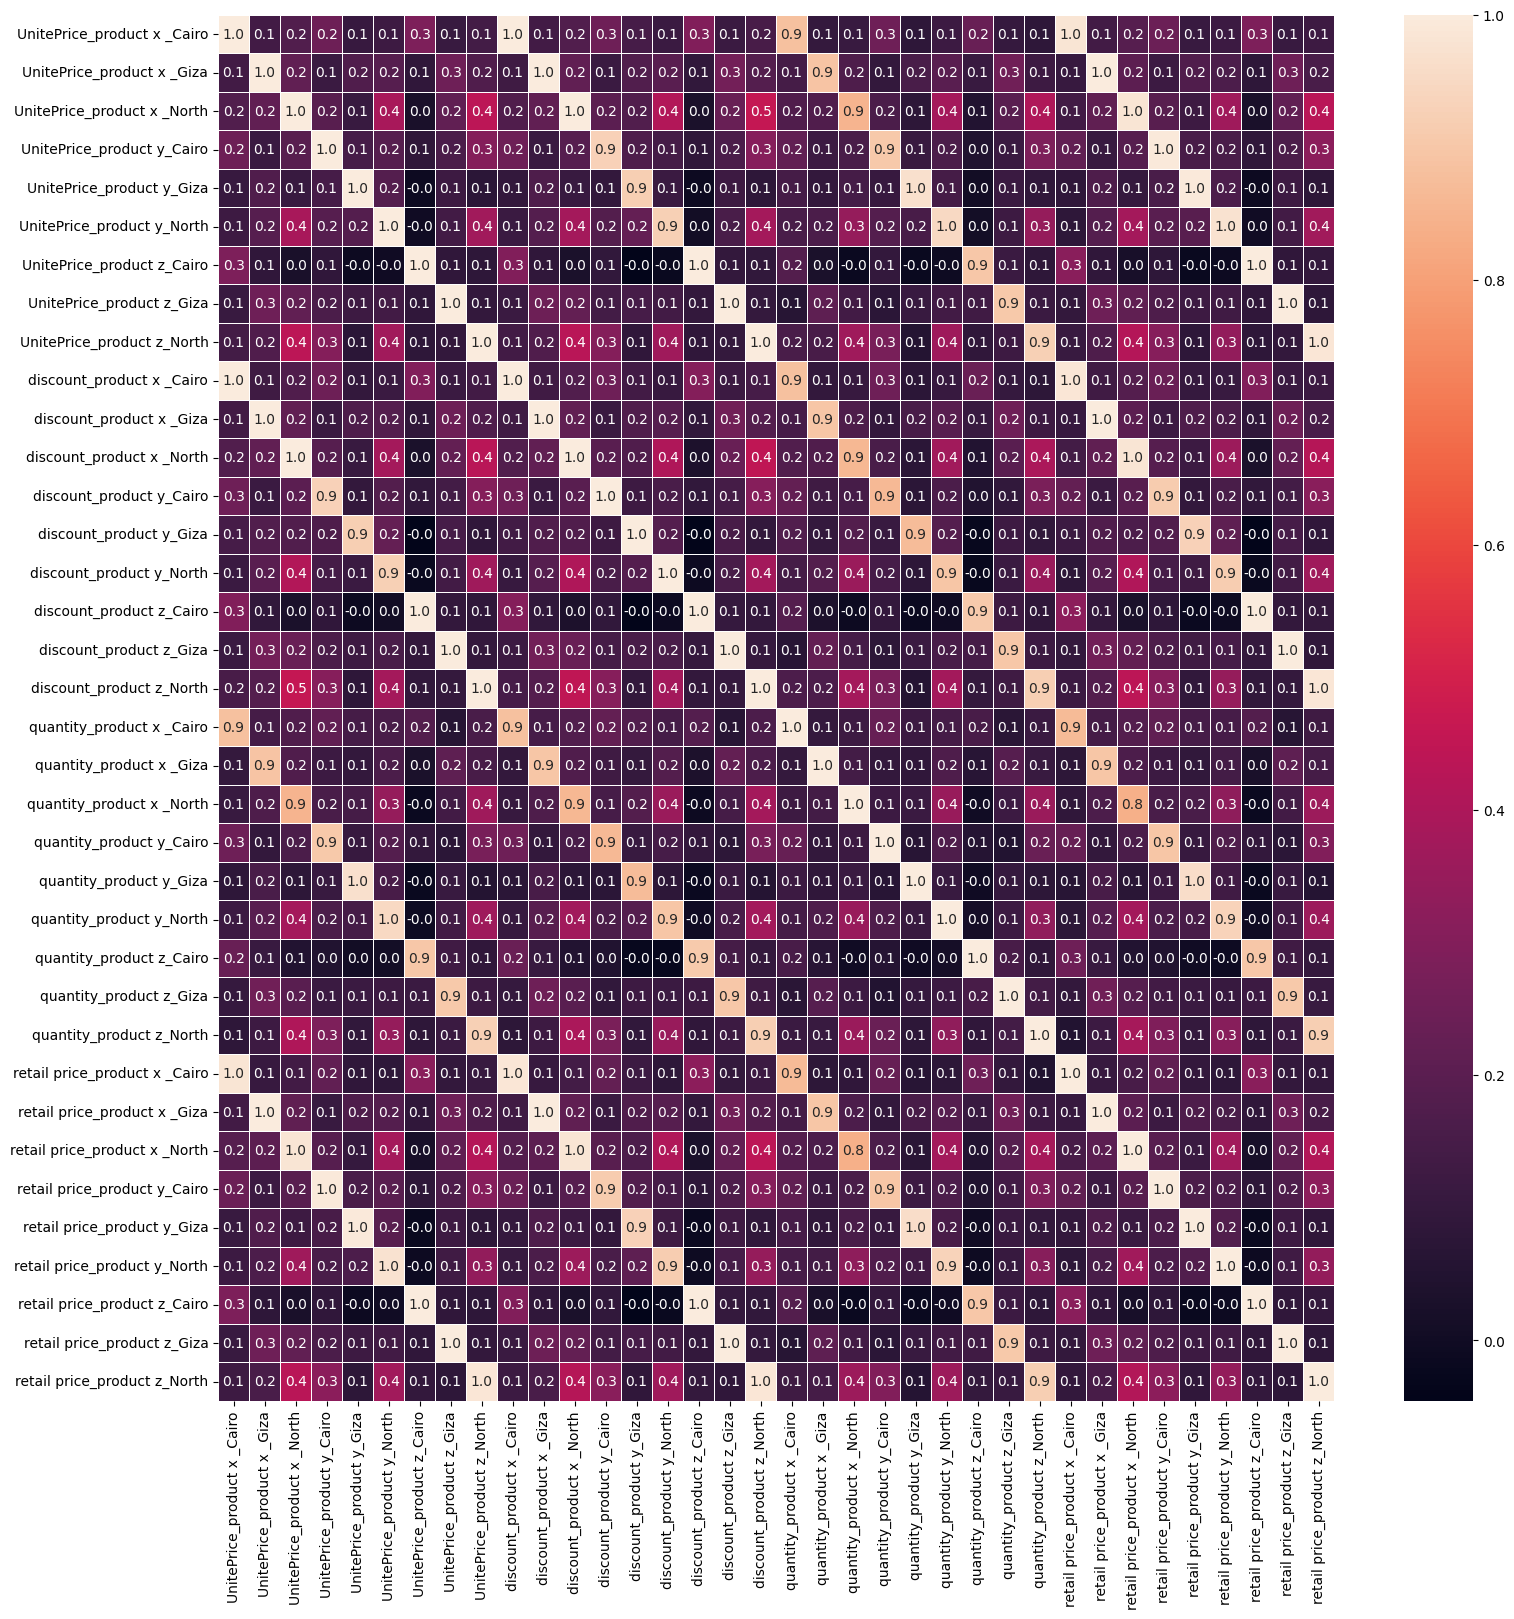

In [ ]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

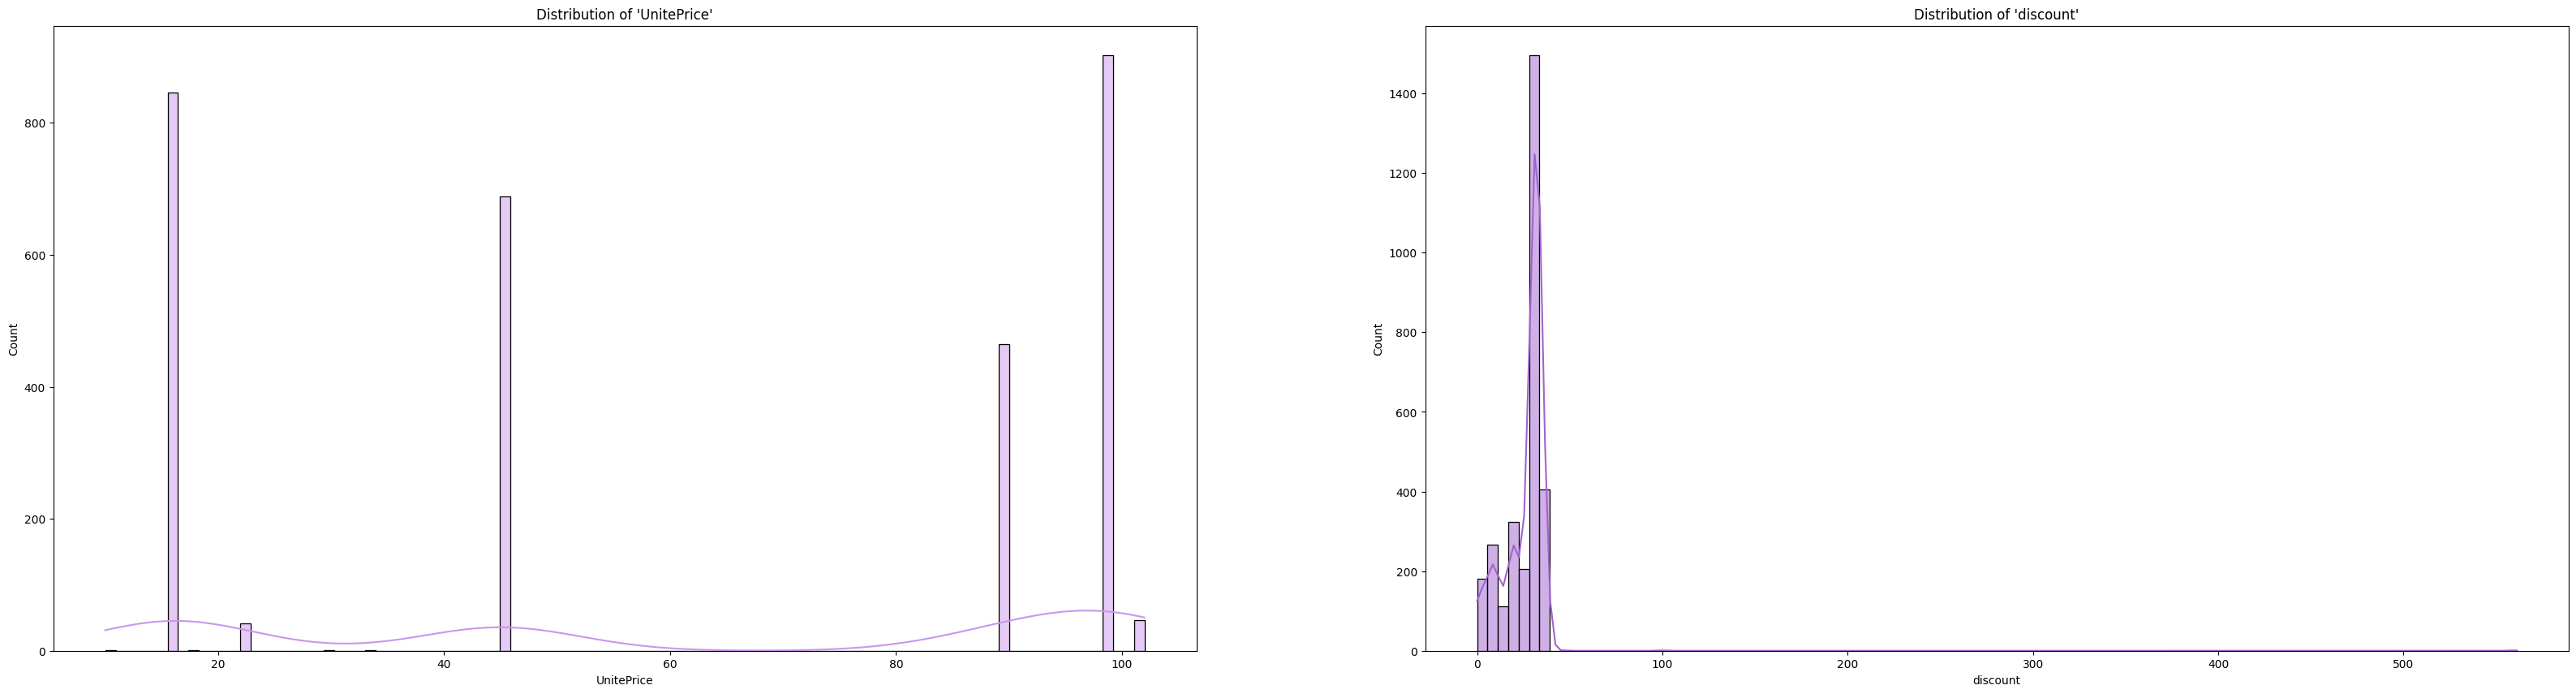

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (40, 10))

sns.histplot(ax = axes[0], x = df["UnitePrice"],
             bins = 100,
             kde = True,
             cbar = True,
             color = "#CA96EC").set(title = "Distribution of 'UnitePrice'");

sns.histplot(ax = axes[1], x = df["discount"],
             bins = 100,
             cbar = True,
             kde = True,
             color = "#A163CF").set(title = "Distribution of 'discount'");


In [ ]:
# multivariate lstm example
from numpy import array
from numpy import hstack
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

In [ ]:
# Select specific columns from the DataFrame
out_cols=['quantity_product x _Cairo', 'quantity_product x _Giza',
       'quantity_product x _North', 'quantity_product y_Cairo',
       'quantity_product y_Giza', 'quantity_product y_North',
       'quantity_product z_Cairo', 'quantity_product z_Giza',
       'quantity_product z_North']
y = pivot_df[out_cols]

X = pivot_df.drop(out_cols, axis=1)


In [ ]:
import numpy as np
def split_sequences_multi_output(data, n_steps, forecast_horizon, n_features_out):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        out_end_ix = end_ix + forecast_horizon - 1
        if out_end_ix > len(data) - 1:
            break
        seq_x = data[i:end_ix, :-n_features_out]  # Exclude future output features
        seq_y = data[end_ix:out_end_ix + 1, -n_features_out:]  # Collect 10-day future outputs
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
n_steps = 40
n_features_out=9
forecast_horizon = 10  # Predict 10 days ahead

In [ ]:
# horizontally stack columns
dataset = hstack((X,y))
# choose a number of time steps

# convert into input/output
X, y = split_sequences_multi_output(dataset, n_steps, forecast_horizon, n_features_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
n_output_features = y.shape[2]  # Number of output features (9)

In [ ]:
import numpy as np
import datetime

# Define your reference date (e.g., 2020-01-01)
reference_date = np.datetime64('2021-03-31')

# Convert datetime.date to number of days since the reference date
def convert_dates_to_days_since_reference(data):
    # Convert to NumPy datetime64 and subtract reference_date to get the timedelta
    return (np.datetime64(data) - reference_date).astype('timedelta64[D]').astype(int)

# Apply this conversion to the first column (which contains datetime.date)
for i in range(X.shape[0]):  # Iterate over each sample
    for j in range(X.shape[1]):  # Iterate over each time step
        if isinstance(X[i, j, 0], datetime.date):  # If the element is a date object
            X[i, j, 0] = convert_dates_to_days_since_reference(X[i, j, 0])

# After converting, X will have numerical days values in place of the dates


In [ ]:
X

array([[[0, 102.0, 0.0, ..., 0.0, 0.0, 0.0],
        [30, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [57, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [224, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [228, 0.0, 102.0, ..., 0.0, 0.0, 0.0],
        [231, 0.0, 102.0, ..., 0.0, 0.0, 0.0]],

       [[30, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [57, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [69, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [228, 0.0, 102.0, ..., 0.0, 0.0, 0.0],
        [231, 0.0, 102.0, ..., 0.0, 0.0, 0.0],
        [234, 0.0, 204.0, ..., 0.0, 0.0, 0.0]],

       [[57, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [69, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [70, 0.0, 0.0, ..., 0.0, 0.0, 45.0],
        ...,
        [231, 0.0, 102.0, ..., 0.0, 0.0, 0.0],
        [234, 0.0, 204.0, ..., 0.0, 0.0, 0.0],
        [235, 0.0, 0.0, ..., 0.0, 0.0, 45.0]],

       ...,

       [[606, 0.0, 99.0, ..., 0.0, 45.0, 180.0],
        [607, 198.0, 594.0, ..., 0.0, 0.0, 45.0],
        [608, 297.0, 99.0

In [ ]:
X = X.astype('float32')
y = y.astype('float32')

In [ ]:
from sklearn.model_selection import train_test_split
# Assuming X and y are your input and output arrays respectively
test_size = 0.2  # 20% of the data for testing
X_test= X[-10:]
y_test= y[-10:]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

# Check the shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (267, 40, 28), y_train shape: (267, 10, 9)
X_test shape: (10, 40, 28), y_test shape: (10, 10, 9)


In [ ]:
print("X shape:", X.shape)  # Expected: (num_samples, n_steps, n_features)
print("y shape:", y.shape)  # Expected: (num_samples, 10)


X shape: (334, 40, 28)
y shape: (334, 10, 9)


In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dropout(0.7))
model.add(Dense(n_output_features * forecast_horizon))  # Output layer adjusted for multi-feature output
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 50)                  │          15,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 90)                  │           4,590 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,390 (79.65 KB)

 Trainable params: 20,390 (79.65 KB)

 Non-trainable params: 0 (0.00 B)

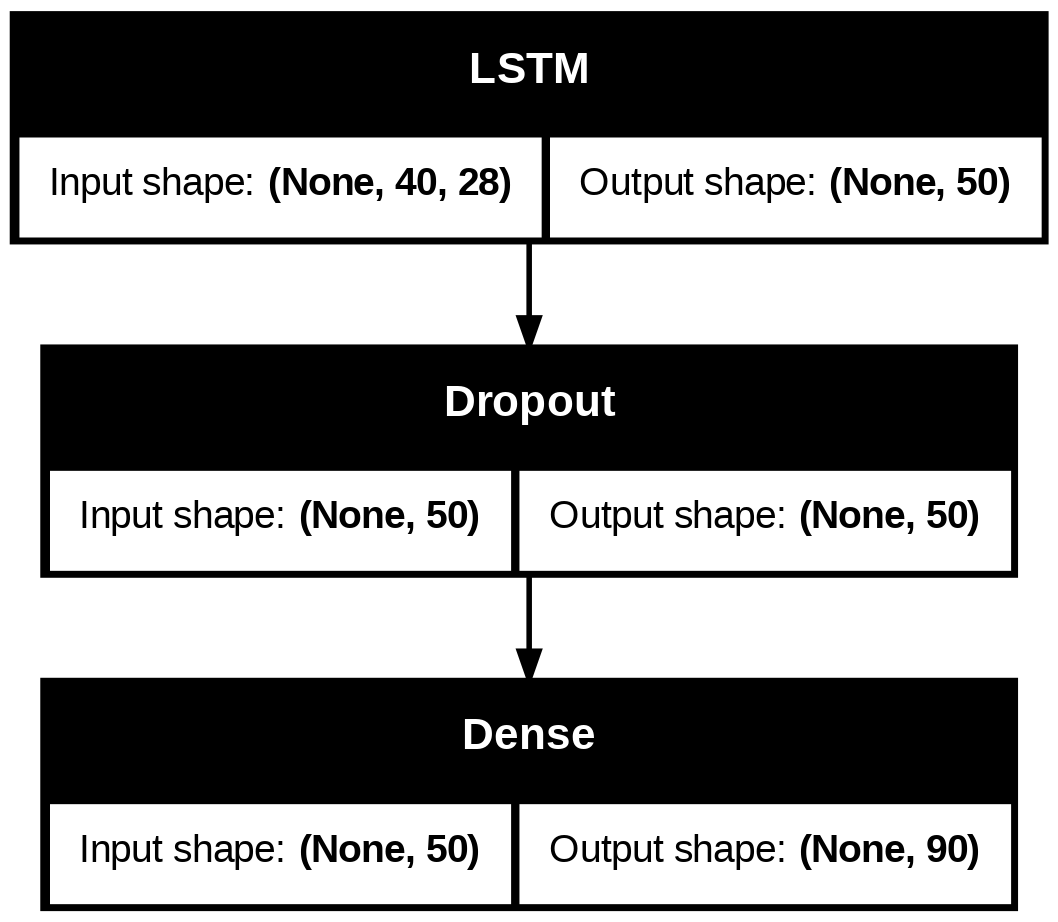

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:

# Train the model
# Train the model with validation data
history = model.fit(X_train, y_train.reshape(y_train.shape[0], -1),
                    epochs=50,
                    verbose=1,
                    validation_data=(X_val, y_val.reshape(y_val.shape[0], -1)))


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 57359.7422 - val_loss: 14821.4746
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 29587.0312 - val_loss: 18620.6758
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 44000.2422 - val_loss: 15439.7393
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 34447.6719 - val_loss: 10312.2373
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 38727.8750 - val_loss: 10942.6104
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18026.9121 - val_loss: 7956.5933
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17890.3125 - val_loss: 8727.2441
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 12633.3887 - val_loss: 3758.6228
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 10796.6846 - val_loss: 3563.3215
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 22792.4512 - val_loss: 28301.3691
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 177951.7188 - val_loss: 13497.0342


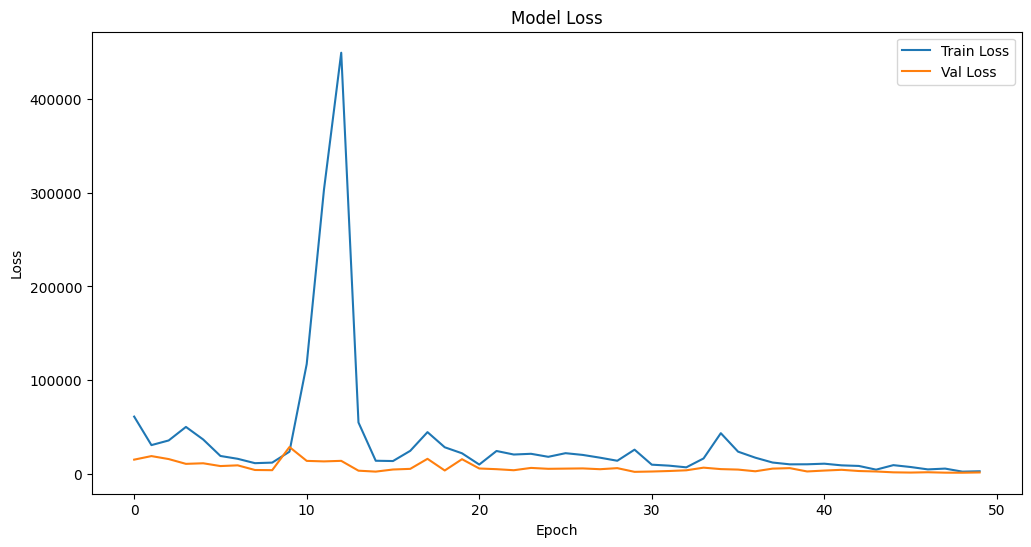

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot additional metrics if added
if 'mae' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()


In [ ]:
  # Making a prediction
yhat = model.predict(X_test, verbose=0)  # Predict future sequences
yhat = yhat.reshape(yhat.shape[0], forecast_horizon, n_output_features)
y = y.astype('int')
yhat- y_test

array([[[ 1.93309784e+00,  5.86612654e+00,  1.62231331e+01,
          1.30834265e+01,  1.51876783e+00, -8.01544189e+00,
          2.66797972e+00, -4.04670572e+00, -1.77569199e+01],
        [ 6.70876741e+00,  6.56912136e+00, -1.45629148e+01,
          1.02900152e+01, -1.84735036e+00, -1.68084908e+00,
          1.55097046e+01,  9.53494740e+00, -6.19591999e+00],
        [-1.22790871e+01, -5.53908825e+00, -2.98045540e+00,
         -1.27488461e+01,  1.29937487e+01,  5.22307014e+00,
         -5.75062561e+00, -7.63020802e+00, -8.87791252e+00],
        [ 3.99455595e+00,  3.63516235e+00, -1.07709074e+01,
         -6.03487396e+00,  5.30911684e+00, -1.19377136e+01,
         -1.93385239e+01, -3.58964920e-01, -9.21300411e+00],
        [-6.63619661e+00,  1.64715385e+01,  1.10792217e+01,
          1.85187130e+01, -3.09695673e+00,  5.77368927e+00,
         -1.19091911e+01,  1.19187355e+01, -1.38408318e+01],
        [ 7.50410843e+00, -8.89332867e+00, -1.08993587e+01,
         -8.26026249e+00,  1.179885

In [ ]:
yhat.shape

(10, 10, 9)

In [ ]:
y_test.shape

(10, 10, 9)

In [ ]:
yhat = yhat.astype('int32')
y_test = y_test.astype('int32')


Combined shape: (10, 10, 18)
Mean Squared Error: 0.16236742081595942
Mean Absolute Error: 0.3291754331065941


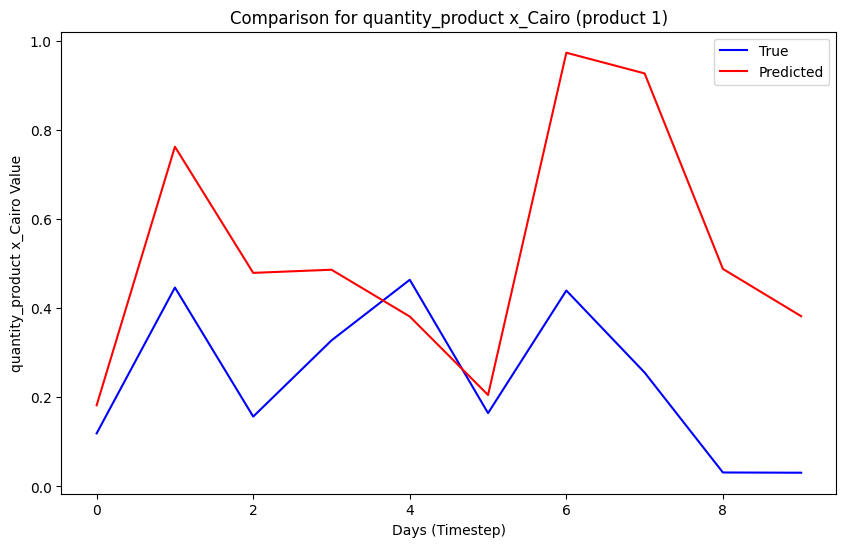

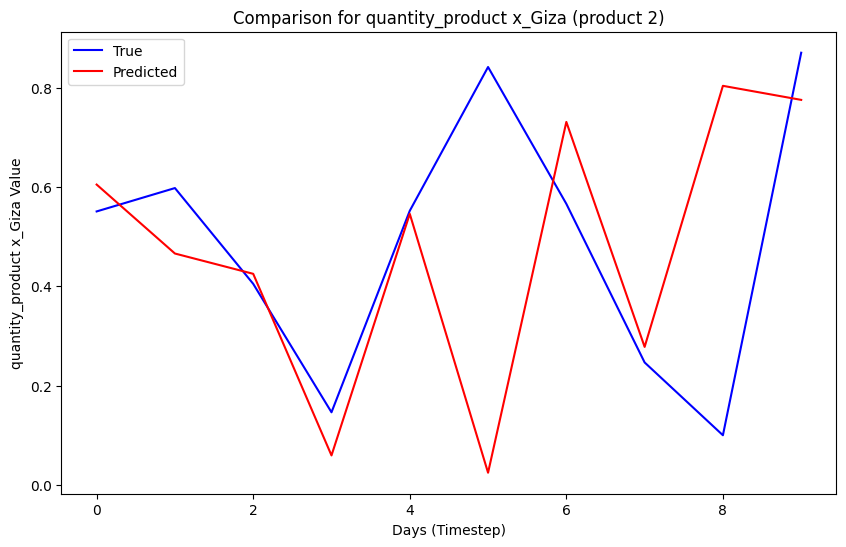

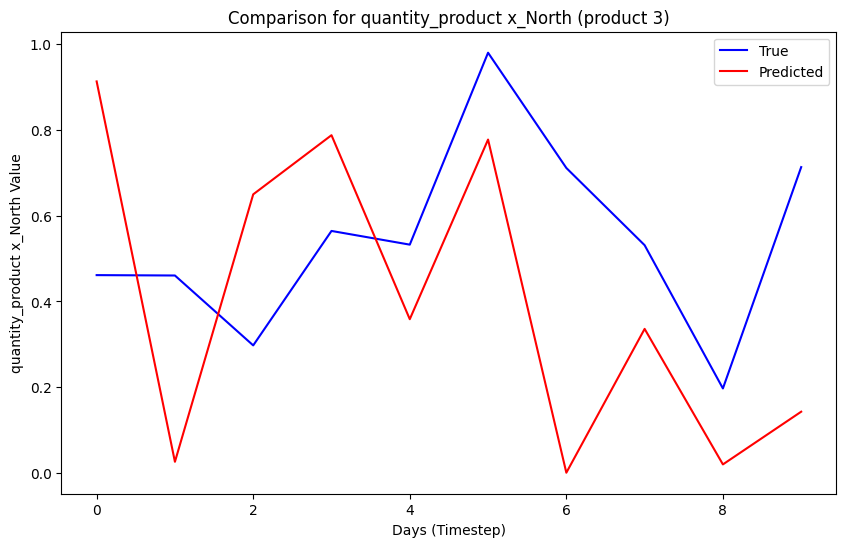

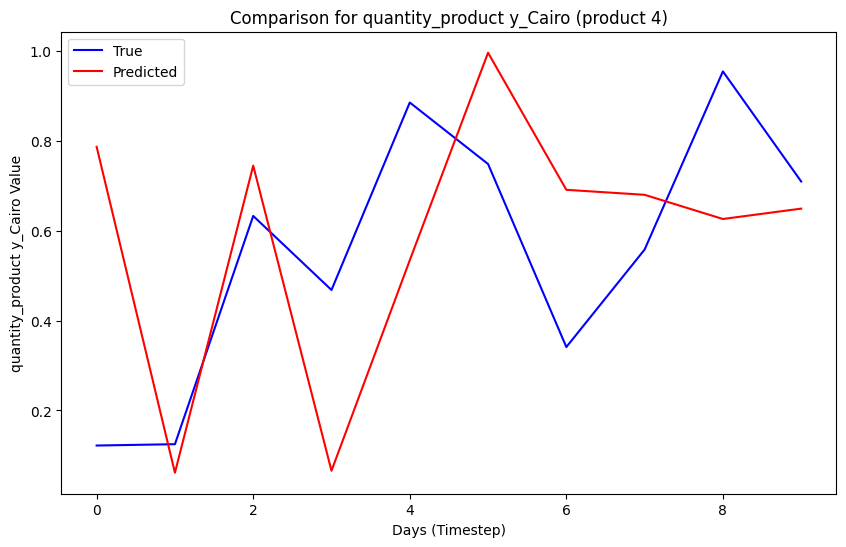

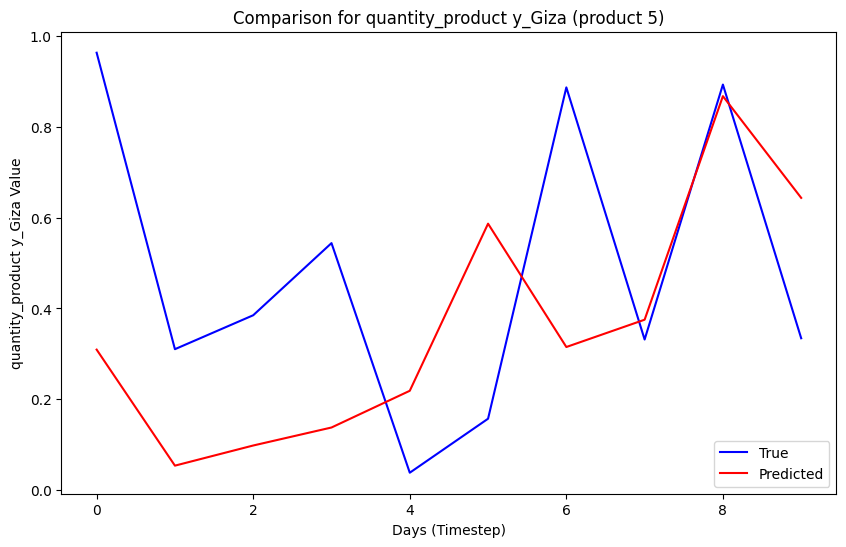

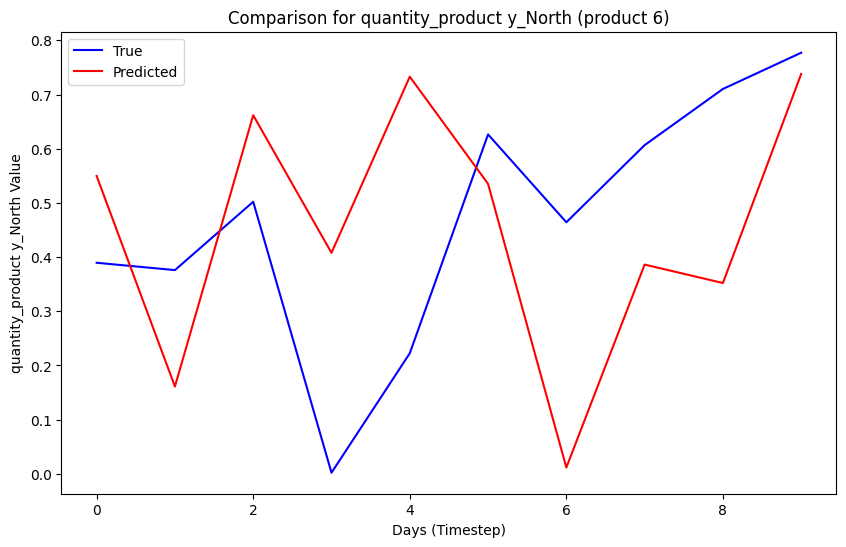

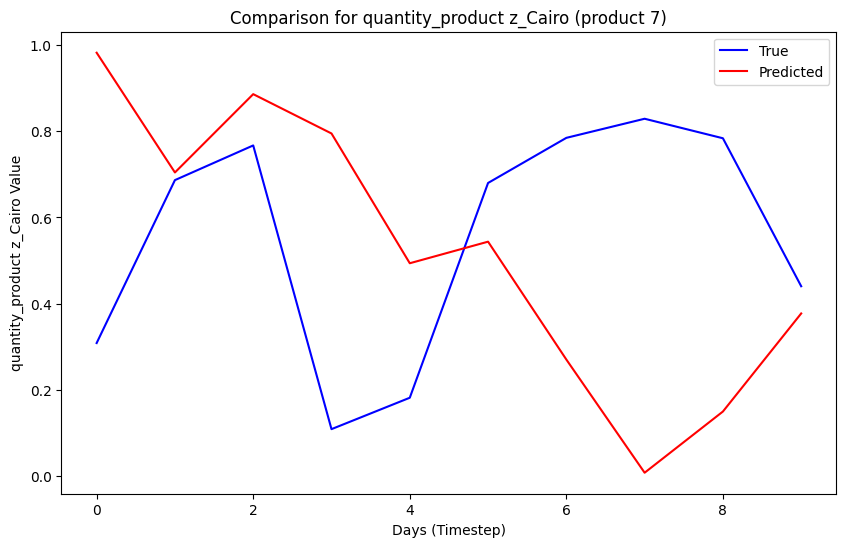

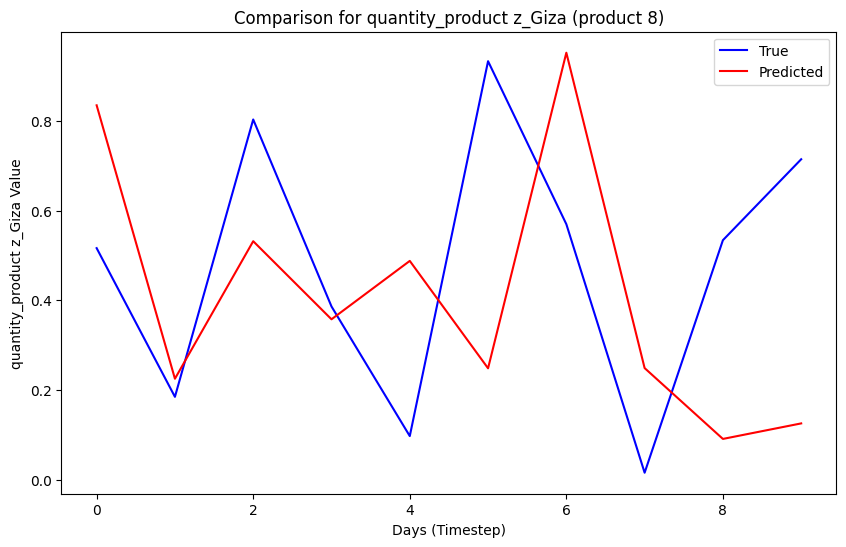

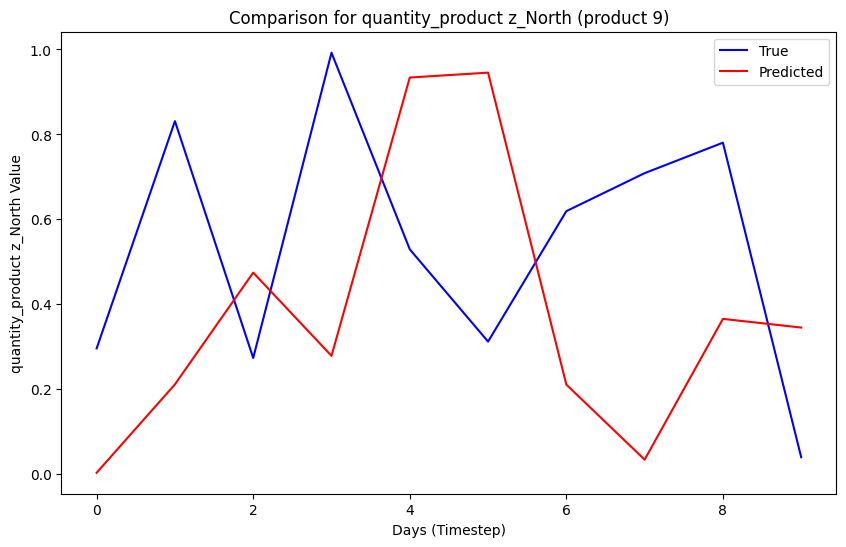

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Sample shape: (samples, timesteps, features)
y_test = np.random.rand(10, 10, 9)  # Actual values for 10 samples, 10 days, 9 products
y_pred = np.random.rand(10, 10, 9)  # Predicted values for 10 samples, 10 days, 9 products

# List of product names
product_names = [
    'quantity_product x_Cairo',
    'quantity_product x_Giza',
    'quantity_product x_North',
    'quantity_product y_Cairo',
    'quantity_product y_Giza',
    'quantity_product y_North',
    'quantity_product z_Cairo',
    'quantity_product z_Giza',
    'quantity_product z_North'
]

# 1. Combine y_test and y_pred for comparison (along the feature axis)
combined = np.concatenate([y_test, y_pred], axis=-1)
print(f"Combined shape: {combined.shape}")

# 2. Compute Mean Squared Error (MSE) for all samples, timesteps, and products
mse = mean_squared_error(y_test.reshape(-1, y_test.shape[-1]),
                         y_pred.reshape(-1, y_pred.shape[-1]), multioutput='uniform_average')
print(f"Mean Squared Error: {mse}")

# 3. Compute Mean Absolute Error (MAE) for all samples, timesteps, and products
mae = mean_absolute_error(y_test.reshape(-1, y_test.shape[-1]),
                          y_pred.reshape(-1, y_pred.shape[-1]), multioutput='uniform_average')
print(f"Mean Absolute Error: {mae}")

# 4. Visualize the comparison for each product over time (for one sample, for simplicity)
sample_idx = 0  # You can loop through other samples if needed
timesteps = y_test.shape[1]
products = y_test.shape[2]

for product_idx in range(products):
    plt.figure(figsize=(10, 6))

    # Plot True values
    plt.plot(range(timesteps), y_test[sample_idx, :, product_idx], label='True', color='blue')

    # Plot Predicted values
    plt.plot(range(timesteps), y_pred[sample_idx, :, product_idx], label='Predicted', color='red')

    plt.title(f"Comparison for {product_names[product_idx]} (product {product_idx + 1})")
    plt.xlabel('Days (Timestep)')
    plt.ylabel(f'{product_names[product_idx]} Value')
    plt.legend()
    plt.show()
